In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score, average_precision_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import randint

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Reading Files

In [2]:
vehicles = pd.read_csv("vehpub_2017.csv")
households = pd.read_csv("hhpub_2017.csv")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
vehicles = vehicles.merge(households[['HOUSEID', 'CNTTDHH', 'CAR', 'PLACE', 'PRICE']], on='HOUSEID', how='left')
vehicles['VEHTYPE'] = vehicles['VEHTYPE'].replace(5, 4)

## Predicting Vehicle Type

### Data Pre-Processing
- Merged household data with vehicle data.
- Experimented with some trip data inputs with little success.

In [17]:
vehicles_type_df = vehicles[(vehicles['VEHTYPE'] > 0)
                            & (vehicles['VEHTYPE'] != 6)
                            & (vehicles['VEHTYPE'] != 97)
                            & (vehicles['HTPPOPDN'] != -9)
                            & (vehicles['CAR'] > 0)
                            & (vehicles['PRICE'] > 0)
                            & (vehicles['PLACE'] > 0)
                            & (vehicles['GSCOST'] != -9)
                            & (vehicles['URBAN'] != 4)]
vehicles_type_df.head(10)

,HOUSEID,VEHID,VEHYEAR,VEHAGE,MAKE,MODEL,FUELTYPE,VEHTYPE,WHOMAIN,OD_READ,HFUEL,VEHOWNED,VEHOWNMO,ANNMILES,HYBRID,PERSONID,TRAVDAY,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,DRVRCNT,HHSTATE,HHSTFIPS,NUMADLT,WRKCOUNT,TDAYDATE,LIF_CYC,MSACAT,MSASIZE,RAIL,URBAN,URBANSIZE,URBRUR,CENSUS_D,CENSUS_R,CDIVMSAR,HH_RACE,HH_HISP,HH_CBSA,SMPLSRCE,WTHHFIN,BESTMILE,BEST_FLG,BEST_EDT,BEST_OUT,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN,GSYRGAL,GSTOTCST,FEGEMPG,FEGEMPGA,GSCOST,FEGEMPGF,CNTTDHH,CAR,PLACE,PRICE
0,30000007,1,2007,10,49,49032,1,1,3,69000,-1,1,-1,1000,2,3,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,14611.926637,1,-1,4,T,50,1500,750,750,20,750,300,487.064221,1126.457778,30,-9,2.312750,1,6,1,2,1
1,30000007,2,2004,13,49,49442,1,2,-8,164000,-1,1,-1,2500,2,-8,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,4767.090946,3,-1,-1,T,50,1500,750,750,20,750,300,250.899523,580.267873,19,-9,2.312750,1,6,1,2,1
2,30000007,3,1998,19,19,19014,1,1,1,120000,-1,1,-1,900,2,1,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,8000.324552,1,-1,-1,T,50,1500,750,750,20,750,300,444.462475,1027.930589,18,-9,2.312750,1,6,1,2,1
3,30000007,4,1997,20,19,19021,1,1,2,-88,-1,1,-1,500,2,2,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,725.932347,2,-1,-1,T,50,1500,750,750,20,750,300,40.329575,93.272224,18,-9,2.312750,1,6,1,2,1
4,30000007,5,1993,24,20,20481,1,4,2,300000,-1,1,-1,10000,2,2,2,1,3,5,7,3,NC,37,3,1,201608,10,3,1,2,1,1,1,5,3,53,2,2,XXXXX,2,187.314320,12437.658757,1,-1,-1,T,50,1500,750,750,20,750,300,888.404197,2054.656806,14,-9,2.312750,1,6,1,2,1
9,30000012,1,2011,6,58,58037,1,1,1,70115,-1,1,-1,11000,2,1,5,1,1,2,10,1,NY,36,1,1,201607,1,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,79.419586,4616.917047,1,-1,-1,C,80,17000,17000,5000,60,17000,7000,219.853193,542.011404,21,-9,2.465333,1,9,1,1,2
10,30000012,2,2004,13,12,12473,1,3,1,68204,-1,1,-1,6000,2,1,5,1,1,2,10,1,NY,36,1,1,201607,1,3,3,2,1,3,1,2,1,23,1,2,XXXXX,2,79.419586,4002.551052,1,-1,-1,C,80,17000,17000,5000,60,17000,7000,250.159441,616.726408,16,-9,2.465333,1,9,1,1,2
11,30000019,1,2006,11,37,37032,1,1,1,120000,-1,1,-1,10000,2,1,5,1,2,2,3,2,MD,24,2,0,201605,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,279.143588,7027.686033,1,-1,-1,S,40,300,300,150,50,750,300,305.551567,745.596748,23,-9,2.440167,1,4,1,3,2
12,30000019,2,1997,20,21,21001,1,1,1,135000,-1,1,-1,5000,2,1,5,1,2,2,3,2,MD,24,2,0,201605,2,3,2,2,1,1,1,5,3,53,1,2,XXXXX,2,279.143588,12833.557760,1,-1,-1,S,40,300,300,150,50,750,300,641.677888,1565.800993,20,-9,2.440167,1,4,1,3,2
13,30000029,1,2016,1,49,49402,1,3,1,8774,-1,2,5,21058,2,1,3,1,2,2,5,2,WI,55,2,0,201610,10,3,3,2,1,2,1,3,2,33,1,2,XXXXX,2,103.240304,14029.079480,1,-1,-1,S,40,1500,750,750,40,1500,750,561.163179,1271.876346,25,-9,2.266500,1,10,1,2,3


In [18]:
vehicles_type_df.loc[vehicles_type_df['VEHTYPE'] == 1, 'VEHTYPE'] = "Automobile"
vehicles_type_df.loc[vehicles_type_df['VEHTYPE'] == 2, 'VEHTYPE'] = "Van"
vehicles_type_df.loc[vehicles_type_df['VEHTYPE'] == 3, 'VEHTYPE'] = "SUV"
vehicles_type_df.loc[vehicles_type_df['VEHTYPE'] == 4, 'VEHTYPE'] = "Truck"
vehicles_type_df.loc[vehicles_type_df['VEHTYPE'] == 7, 'VEHTYPE'] = "Motorcycle"

### Training Data Distribution

In [20]:
vehicles_type_df['VEHTYPE'].value_counts(normalize=True)

VEHTYPE
Automobile    0.526543
SUV           0.247824
Truck         0.147962
Van           0.053154
Motorcycle    0.024517
Name: proportion, dtype: float64

### Basic Multinomial Logistic Regression                   

In [21]:
X = vehicles_type_df[['HTPPOPDN', 'HHSIZE', 'HHVEHCNT']]
y = vehicles_type_df['VEHTYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
lr_model = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs', max_iter=1500)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

  Automobile       0.63      0.23      0.34     18507
  Motorcycle       0.08      0.80      0.14       880
         SUV       0.26      0.09      0.13      8725
       Truck       0.17      0.24      0.20      5341
         Van       0.09      0.42      0.15      1886

    accuracy                           0.22     35339
   macro avg       0.24      0.36      0.19     35339
weighted avg       0.42      0.22      0.25     35339



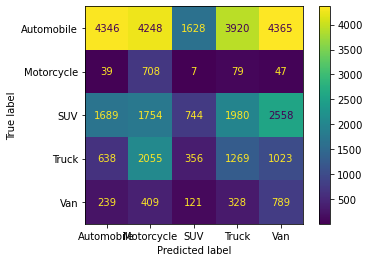

In [23]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Automobile', 'Motorcycle', 'SUV', 'Truck', 'Van']).plot();

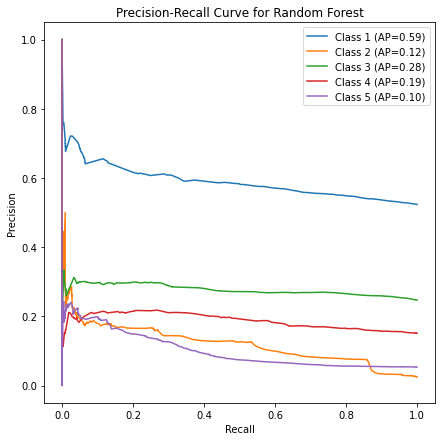

In [24]:
y_prob = lr_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=['Automobile', 'Motorcycle', 'SUV', 'Truck', 'Van'])

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(1, 6):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i-1], y_prob[:, i-1])
    average_precision[i] = average_precision_score(y_test_bin[:, i-1], y_prob[:, i-1])

# Plot the precision-recall curves
plt.figure(figsize=(7, 7))

for i in range(1, 6):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend()
plt.show()

### Random Forest Classifier

In [25]:
X = vehicles_type_df[['CAR', 'CNTTDHH', 'CDIVMSAR', 'GSCOST', 'HTPPOPDN', 'HHSIZE', 'HHFAMINC', 'HHVEHCNT', 'PRICE', 'PLACE']]
y = vehicles_type_df['VEHTYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Hyperparameter Tuning
- OPTIONAL - High computational load

In [ ]:
param_dist = {'n_estimators': randint(250, 750), 'max_depth': randint(50, 150)}
rfc = RandomForestClassifier(class_weight='balanced')
rand_search = RandomizedSearchCV(rfc, param_distributions = param_dist, n_iter=5, cv=5)
rand_search.fit(X_train, y_train)

In [ ]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:', rand_search.best_params_)

### Run Model 

In [26]:
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=500, max_depth=100)
rf_model.fit(X_train, y_train);
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred)) 

Classification Report:
               precision    recall  f1-score   support

  Automobile       0.56      0.56      0.56     18562
  Motorcycle       0.15      0.28      0.20       866
         SUV       0.27      0.23      0.25      8840
       Truck       0.15      0.17      0.16      5137
         Van       0.09      0.10      0.10      1934

    accuracy                           0.39     35339
   macro avg       0.24      0.27      0.25     35339
weighted avg       0.39      0.39      0.39     35339



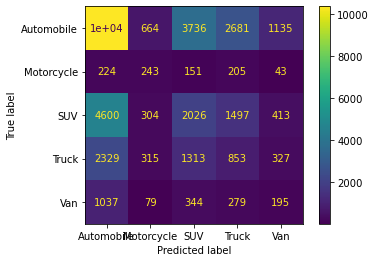

In [27]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Automobile', 'Motorcycle', 'SUV', 'Truck', 'Van']).plot();

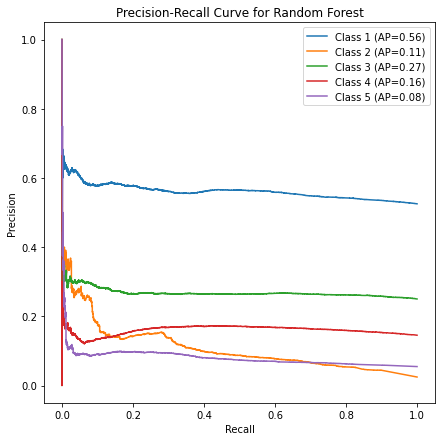

In [28]:
y_prob = rf_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=['Automobile', 'Motorcycle', 'SUV', 'Truck', 'Van'])

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(1, 6):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i-1], y_prob[:, i-1])
    average_precision[i] = average_precision_score(y_test_bin[:, i-1], y_prob[:, i-1])

# Plot the precision-recall curves
plt.figure(figsize=(7, 7))

for i in range(1, 6):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend()
plt.show()

## Predicting Vehicle Fuel Type
- Random Forest Model

In [29]:
vehicles['FUELTYPE'] = vehicles['FUELTYPE'].replace(6, 4)
vehicles_fuel_df = vehicles[(vehicles['FUELTYPE'] > 0)
                            & (vehicles['FUELTYPE'] != 97)
                            & (vehicles['HTPPOPDN'] != -9)
                            & (vehicles['HHFAMINC'] > 0)
                            & (vehicles['CAR'] > 0)
                            & (vehicles['PRICE'] > 0)
                            & (vehicles['PLACE'] > 0)
                            & (vehicles['URBAN'] != 4)]

In [30]:
vehicles_fuel_df.loc[vehicles_fuel_df['FUELTYPE'] == 1, 'FUELTYPE'] = "Gas"
vehicles_fuel_df.loc[vehicles_fuel_df['FUELTYPE'] == 2, 'FUELTYPE'] = "Diesel"
vehicles_fuel_df.loc[vehicles_fuel_df['FUELTYPE'] == 3, 'FUELTYPE'] = "Hybrid"

In [42]:
X = vehicles_fuel_df[['CAR', 'CNTTDHH', 'CDIVMSAR', 'HTPPOPDN', 'HHSIZE', 'HHFAMINC', 'PRICE', 'PLACE']]
y = vehicles_fuel_df['FUELTYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train, y_train);
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred)) 

Classification Report:
               precision    recall  f1-score   support

      Diesel       0.07      0.15      0.09       714
         Gas       0.96      0.92      0.94     33408
      Hybrid       0.11      0.15      0.12      1002

    accuracy                           0.89     35124
   macro avg       0.38      0.41      0.39     35124
weighted avg       0.91      0.89      0.90     35124



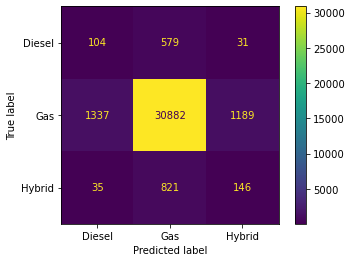

In [44]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Diesel', 'Gas', 'Hybrid']).plot();

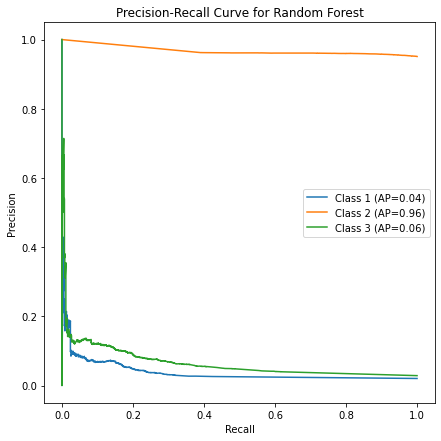

In [45]:
y_prob = rf_model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=['Diesel', 'Gas', 'Hybrid'])

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(1, 4):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i-1], y_prob[:, i-1])
    average_precision[i] = average_precision_score(y_test_bin[:, i-1], y_prob[:, i-1])

# Plot the precision-recall curves
plt.figure(figsize=(7, 7))

for i in range(1, 4):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AP={average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend()
plt.show()

## Predicting Vehicle Age
- Multiple Linear Regression Model

In [35]:
vehicles_age_df = vehicles[(vehicles['VEHAGE'] < 40)
                           & (vehicles['VEHAGE'] > 0)
                           & (vehicles['HTPPOPDN'] != -9)
                           & (vehicles['HHFAMINC'] > 0)
                           & (vehicles['CAR'] > 0)
                           & (vehicles['PRICE'] > 0)
                           & (vehicles['PLACE'] > 0)
                           & (vehicles['URBAN'] != 4)]

In [36]:
X = vehicles_age_df[['CAR', 'CNTTDHH', 'CDIVMSAR', 'GSCOST', 'HHSIZE', 'HHFAMINC', 'HHVEHCNT', 'PRICE']]
y = vehicles_age_df['VEHAGE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train);

In [38]:
y_pred = lr_model.predict(X_test)

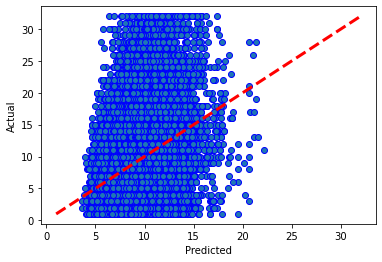

In [39]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

### Normalized Root Mean Squared Error
- Relative Root Mean Squared Error (RRMSE) is a variant of Root Mean Squared Error (RMSE), gauging predictive model accuracy relative to the target variable range. It normalizes RMSE by the target variable range and presents it as a percentage for easy cross-dataset or cross-variable comparison. RRMSE, a dimensionless form of RMSE, scales residuals against actual values, allowing comparison of different measurement techniques.

In [40]:
def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

In [41]:
print('RRMSE:', relative_root_mean_squared_error(y_test, y_pred))

RRMSE: 0.6253414167393782
